In [2]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd
import nltk


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# Keras
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot

# Sklearn
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
# Impoert Dataset

In [4]:
data = 'Dataset/Tweets.csv'
df = pd.read_csv(data)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
# Cek NaN Values

In [7]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [8]:
# Cleaning and Rename Columns

In [9]:
unused_data = df[['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']]
df = df.drop(columns=unused_data)
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [10]:
df.rename (columns= {'airline_sentiment': 'Sentiment'}, inplace=True)
df.rename (columns= {"text": 'Text'}, inplace=True)
df

,Sentiment,Text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [11]:
df.Sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [13]:
# Plotting Distibusi Dataset

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

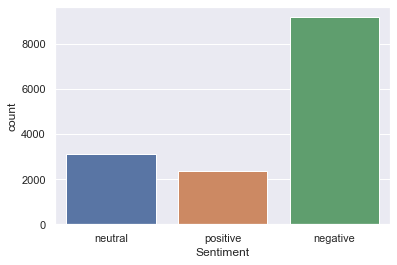

In [14]:
sns.set(style="darkgrid")
sns.countplot(x = "Sentiment" , data = df)

In [15]:
# Create WordCloud Positive Sentiment

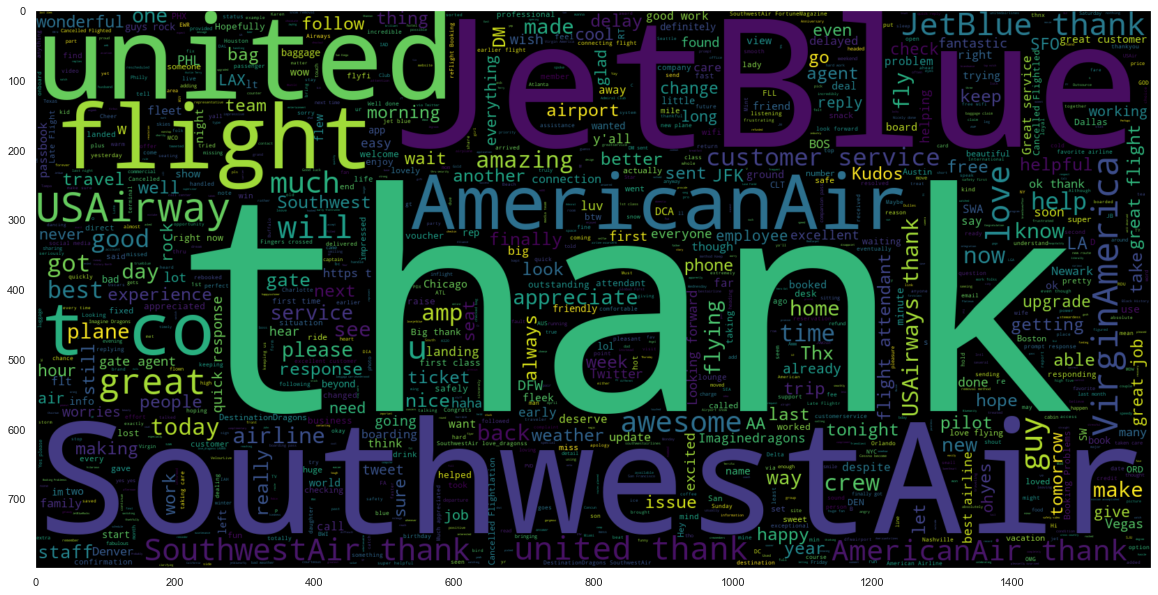

In [16]:
plt.figure(figsize = (20,20))
plt.grid(False)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.Sentiment == 'positive'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [17]:
# Create WordCloud Neegative Sentiment

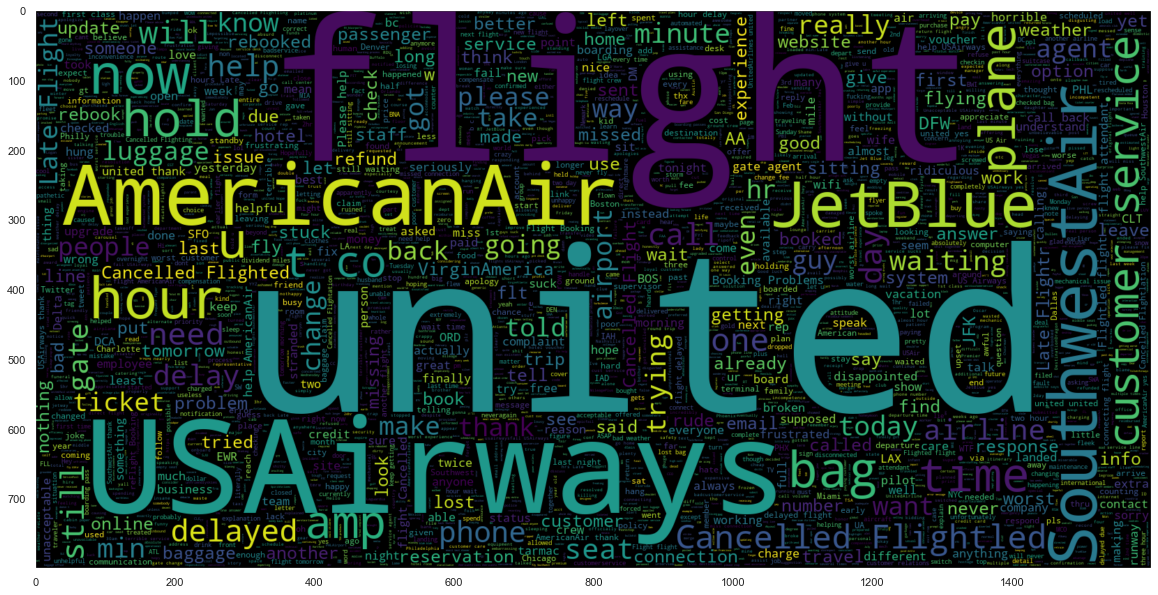

In [18]:
plt.figure(figsize = (20,20)) # Negative Sentiment
plt.grid(False)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.Sentiment == 'negative'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [19]:
# Create WordCloud Neutral Sentiment

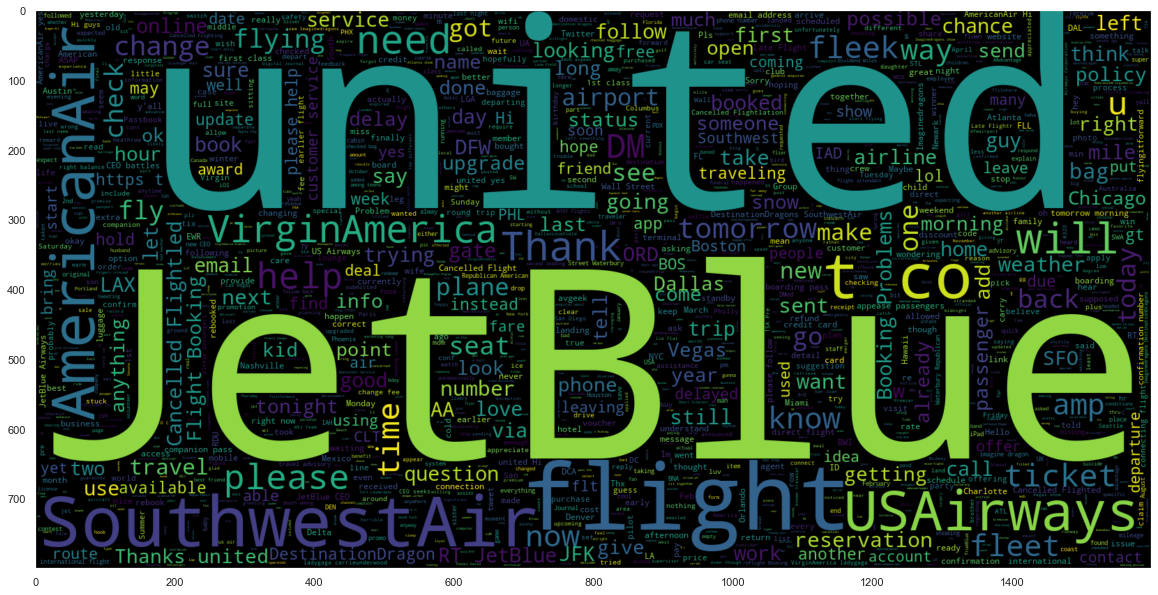

In [20]:
plt.figure(figsize = (20,20)) # Neutral Sentiment
plt.grid(False)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.Sentiment == 'neutral'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [21]:
# Preprocess Text

In [22]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

In [23]:
def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [24]:
def check_scores(clf, X_train, X_test, y_train, y_test):
  model = clf.fit(X_train, y_train)
  predicted_class = model.predict(X_test)
  predicted_class_train = model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

In [25]:
df['cleaned_tweet'] = df['Text'].apply(clean_the_tweet)
df.head()

,Sentiment,Text,cleaned_tweet
0,neutral,@VirginAmerica What @dhepburn said.,dhepburn said
1,positive,@VirginAmerica plus you've added commercials t...,you ve added commercials to the experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,didn t today must mean i need to take another ...
3,negative,@VirginAmerica it's really aggressive to blast...,s really aggressive to blast obnoxious enterta...
4,negative,@VirginAmerica and it's a really big bad thing...,it s a really big bad thing about it


In [26]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,Sentiment,Text,cleaned_tweet
0,0,@VirginAmerica What @dhepburn said.,dhepburn said
1,1,@VirginAmerica plus you've added commercials t...,you ve added commercials to the experience tacky
2,0,@VirginAmerica I didn't today... Must mean I n...,didn t today must mean i need to take another ...
3,0,@VirginAmerica it's really aggressive to blast...,s really aggressive to blast obnoxious enterta...
4,0,@VirginAmerica and it's a really big bad thing...,it s a really big bad thing about it


In [27]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])
 
def check_scores(clf, X_train, X_test, y_train, y_test):
  model = clf.fit(X_train, y_train)
  predicted_class = model.predict(X_test)
  predicted_class_train = model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))
  print()

  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()

  print(classification_report(y_test,predicted_class)) 
  print() 

  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

In [28]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['Sentiment'], random_state=42)

In [29]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)

model=Sequential()
model.add(Dense(512, input_dim = max_sent_length, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['Sentiment'])
X_final.shape, y_final.shape

((14640, 159), (14640,))

In [30]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_NN, y_train_NN, validation_data = (X_test_NN, y_test_NN), epochs=10, batch_size=64)

Epoch 1/10
161/161 [==============================] - 13s 23ms/step - loss: 0.4551 - accuracy: 0.8269 - val_loss: 0.4072 - val_accuracy: 0.8434
Epoch 2/10
161/161 [==============================] - 5s 30ms/step - loss: 0.4285 - accuracy: 0.8364 - val_loss: 0.4110 - val_accuracy: 0.8427
Epoch 3/10
161/161 [==============================] - 1s 6ms/step - loss: 0.4271 - accuracy: 0.8353 - val_loss: 0.4061 - val_accuracy: 0.8434
Epoch 4/10
161/161 [==============================] - 4s 27ms/step - loss: 0.4251 - accuracy: 0.8376 - val_loss: 0.4066 - val_accuracy: 0.8427
Epoch 5/10
161/161 [==============================] - 3s 16ms/step - loss: 0.4238 - accuracy: 0.8367 - val_loss: 0.4110 - val_accuracy: 0.8443
Epoch 6/10
161/161 [==============================] - 3s 18ms/step - loss: 0.4254 - accuracy: 0.8353 - val_loss: 0.4119 - val_accuracy: 0.8420
Epoch 7/10
161/161 [==============================] - 3s 18ms/step - loss: 0.4237 - accuracy: 0.8363 - val_loss: 0.4035 - val_accuracy: 0.8422

In [31]:
y_test_pred_NN=np.round(model.predict(X_test_NN))
y_train_pred_NN=np.round(model.predict(X_train_NN))
y_test_pred_NN

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [32]:
test_acc_NN = accuracy_score(y_test_NN, y_test_pred_NN)
train_acc_NN = accuracy_score(y_train_NN, y_train_pred_NN)
test_roc_NN = roc_auc_score(y_test_NN, y_test_pred_NN)
train_roc_NN = roc_auc_score(y_train_NN, y_train_pred_NN)

In [33]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.4))
model.add(LSTM(512))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['Sentiment'])
X_final.shape,y_final.shape

((14640, 159), (14640,))

In [34]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_LSTM, y_train_LSTM, validation_data = (X_test_LSTM, y_test_LSTM), epochs=10, batch_size=128)

Epoch 1/10
81/81 [==============================] - 357s 4s/step - loss: 0.4842 - accuracy: 0.8297 - val_loss: 0.4332 - val_accuracy: 0.8420
Epoch 2/10
81/81 [==============================] - 333s 4s/step - loss: 0.4398 - accuracy: 0.8341 - val_loss: 0.3523 - val_accuracy: 0.8629
Epoch 3/10
81/81 [==============================] - 335s 4s/step - loss: 0.3299 - accuracy: 0.8637 - val_loss: 0.3246 - val_accuracy: 0.8736
Epoch 4/10
81/81 [==============================] - 332s 4s/step - loss: 0.2738 - accuracy: 0.8863 - val_loss: 0.3286 - val_accuracy: 0.8768
Epoch 5/10
81/81 [==============================] - 339s 4s/step - loss: 0.2373 - accuracy: 0.9073 - val_loss: 0.3269 - val_accuracy: 0.8766
Epoch 6/10
81/81 [==============================] - 328s 4s/step - loss: 0.2105 - accuracy: 0.9180 - val_loss: 0.3398 - val_accuracy: 0.8807
Epoch 7/10
81/81 [==============================] - 336s 4s/step - loss: 0.1877 - accuracy: 0.9265 - val_loss: 0.3494 - val_accuracy: 0.8568
Epoch 8/10
81

In [35]:
y_test_pred_LSTM=np.round(model.predict(X_test_LSTM))
y_train_pred_LSTM=np.round(model.predict(X_train_LSTM))
y_test_pred_LSTM

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [36]:
test_acc_LSTM = accuracy_score(y_test_LSTM, y_test_pred_LSTM)
train_acc_LSTM = accuracy_score(y_train_LSTM, y_train_pred_LSTM)
test_roc_LSTM = roc_auc_score(y_test_LSTM, y_test_pred_LSTM)
train_roc_LSTM = roc_auc_score(y_train_LSTM, y_train_pred_LSTM)

Train confusion matrix is: 
[[9197    2]
 [1650  131]]

Test confusion matrix is: 
[[3071    7]
 [ 561   21]]

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      3078
           1       0.75      0.04      0.07       582

    accuracy                           0.84      3660
   macro avg       0.80      0.52      0.49      3660
weighted avg       0.83      0.84      0.78      3660


Train accuracy score:  0.8495446265938069
Test accuracy score:  0.8448087431693989

Train ROC-AUC score:  0.9070299978289026
Test ROC-AUC score:  0.849078316575453

Are under Precision-Recall curve: 0.06885245901639343
Area under ROC-AUC: 0.5031851307062738


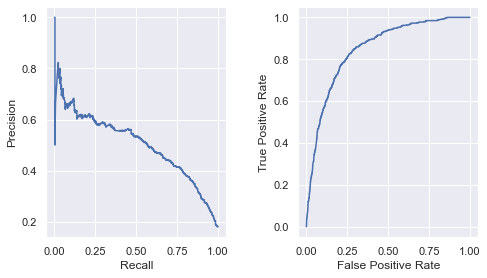

In [37]:
m_naive_bayes = MultinomialNB()
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(m_naive_bayes ,x_train, x_test, y_train, y_test)

In [44]:
model = Sequential()
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
X_train_SRNN, X_test_SRNN, y_train_SRNN, y_test_SRNN = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_SRNN, y_train_SRNN, validation_data = (X_test_SRNN, y_test_SRNN), epochs=10, batch_size=64)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Fajri\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Fajri\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Fajri\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Fajri\anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Fajri\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Fajri\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_6" (type Sequential).
    
    Input 0 of layer "simple_rnn_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 159)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 159), dtype=int32)
      • training=True
      • mask=None


In [ ]:
y_test_pred_SRNN=np.round(model.predict(X_test_SRNN))
y_train_pred_SRNN=np.round(model.predict(X_train_SRNN))
y_test_pred_SRNN

In [46]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.4))
model.add(GRU(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['Sentiment'])
X_final.shape,y_final.shape

((14640, 159), (14640,))

In [ ]:
X_train_GRU, X_test_GRU, y_train_GRU, y_test_GRU = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_GRU, y_train_GRU, validation_data = (X_test_GRU, y_test_GRU), epochs=10, batch_size=64)

Epoch 1/10
161/161 [==============================] - 535s 3s/step - loss: 0.4047 - accuracy: 0.8464 - val_loss: 0.3139 - val_accuracy: 0.8766
Epoch 2/10
106/161 [==================>...........] - ETA: 2:44 - loss: 0.2612 - accuracy: 0.8908

In [ ]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimized,x_train, x_test, y_train, y_test)

In [ ]:
data = [('Artificial Neural Network',train_acc_NN, test_acc_NN, train_roc_NN, test_roc_NN),
        ('LSTM',train_acc_LSTM, test_acc_LSTM, train_roc_LSTM, test_roc_LSTM),
        ('Multinomial Naive Bayes',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc),
        ('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
        ('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc)]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_